In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from scipy.stats import norm, beta
import matplotlib.patches as patches
from numpy.random import default_rng
rng = default_rng()
%matplotlib inline

# introduction to ROC diagrams

So-called "receiver operating characteristic" (ROC) diagrams use a two-dimensional space of “probability of detection” ($POD=\frac{a}{a+c}$) and “probability of false detection” ($POFD=\frac{b}{b+d}$) for visualizing forecast performance (Peterson and Birdsall 1953; Swets 1973; Mason 1989). ROC diagrams provide information regarding the ability of a forecast system to discriminate between the occurrence and non-occurrence of observed events. While ROC curves are mathematically independent of base rate (Ferro and Stephenson 2011), in practice the behavior of forecast performance when displayed in ROC space depends strongly on base rate (Santika 2011). ROC diagrams are widely-used, Dimitriadis et al. (2023) proposed a triptych of diagrams (Murphy, reliability, and ROC) to allow for quick analysis of the various aspects of forecast performance represented in each of these spaces. In this notebook, we introduce the ROC diagram and show how to display any other score from the 2x2 contingency table in the background, such as frequency bias.

## 2x2 contingency table

Forecasts for a well-defined observed event can be evaluated by analyzing the elements of a 2x2 contingency table (see intro_2x2_table.ipynb for more details). A generic form of the 2x2 contingency table is shown below. The observed value for the $i^{th}$ case can be denoted as $obs=yes$ when the event was observed to occur,  $obs=no$ when the event did not occur. Forecasts could be provided in one of several forms: continuous (e.g., probabilistic), ordinal (e.g., slight/moderate/high), or binary (yes/no). Continuous and ordinal forecast values can be converted to binary forecasts via thresholding, $fcst=yes$ when the forecast value is greater than or equal to a threshold,  $fcst=no$ otherwise. The elements of the contingency table are simply the relative frequencies or proportions of each contingency (joint probabilities).

The “a” element of the contingency table provides the proportion of correct “yes” forecasts, often referred to as “true positives” or “hits”. The “b” element provides the proportion of incorrect “yes” forecasts, also known as “false positives” or “false alarms”. The “c” element provides the proportion of incorrect “no” forecasts, also denoted as “false negatives” or “missed events”. The “d” element provides the proportion of correct “no” forecasts, also called “true negatives” or “correct nulls”.

In [2]:
# generic 2x2 contingency table
pd.DataFrame(data=np.array([['a','b','a+b'],['c','d','c+d'],['a+c','b+d','1']]),index=['fcst=yes','fcst=no','col sum'],columns=['obs=yes','obs=no','row sum'])

,obs=yes,obs=no,row sum
fcst=yes,a,b,a+b
fcst=no,c,d,c+d
col sum,a+c,b+d,1


## 2x2 contingency table in ROC space

We can use the definitions of $POD=\frac{a}{a+c},POFD=\frac{b}{b+d},$ along with the base rate $\bar x = a+c$ to express the elements of the 2x2 contingency table in terms of $POD$, $POFD$, and $\bar x$, this will come in handy later:

In [3]:
# generic 2x2 contingency table in terms of POD, POFD, and base rate
pd.DataFrame(data=np.array([[r'$\bar x (POD)$',r'$(1-\bar x)POFD$',r'$\bar x (POD)+(1-\bar x)POFD$'],[r'$\bar x (1-POD)$',r'$(1-\bar x)(1-POFD)$',r'$1-\bar x (POD)+(1-\bar x)POFD$'],[r'$\bar x$',r'$1-\bar x$','1']]),index=['fcst=yes','fcst=no','col sum'],columns=['obs=yes','obs=no','row sum'])

,obs=yes,obs=no,row sum
fcst=yes,$\bar x (POD)$,$(1-\bar x)POFD$,$\bar x (POD)+(1-\bar x)POFD$
fcst=no,$\bar x (1-POD)$,$(1-\bar x)(1-POFD)$,$1-\bar x (POD)+(1-\bar x)POFD$
col sum,$\bar x$,$1-\bar x$,1


## example

We'll use a simple model of the discrimination ability of a forecast system, following Brooks (2004) and originating with classic work by Thurstone (1927). We assume that the conditional distributions of the forecast values ($p(fcst|obs=yes)$ and $p(fcst|obs=no)$) follow a normal distribution with equal variances, separated by $d'$ which is typically expressed in terms of the number of standard deviations between them. In the following example, $d'=1.2$

Text(0.5, 1.0, "conditional dists standard normal separated by d'=1.2")

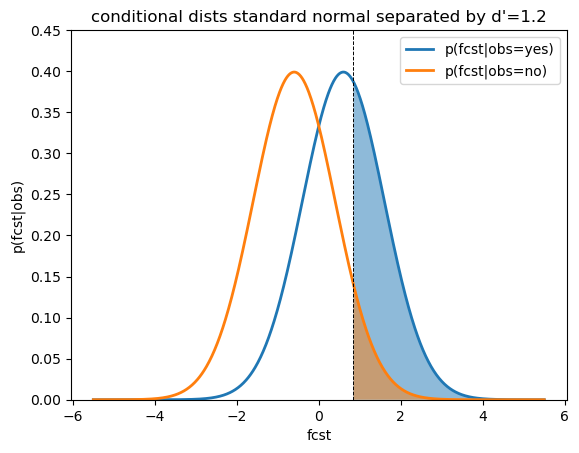

In [4]:
# plot a discrimination diagram for standard normal distribution conditional forecast distributions separated by dprime1
fig,ax = plt.subplots()
dprime1=1.2
x1=np.linspace(-5.5,5.5,1001)
p1=norm.pdf(x1,loc=0.5*dprime1,scale=1.)
p0=norm.pdf(x1,loc=-0.5*dprime1,scale=1.)
ax.plot(x1,p1,label='p(fcst|obs=yes)',lw=2.)
ax.plot(x1,p0,label='p(fcst|obs=no)',lw=2.)
ax.plot([x1[577],x1[577]],[0,0.45],'k--',lw=0.7)
ax.fill_between(x1[577:],p1[577:],alpha=0.5)
ax.fill_between(x1[577:],p0[577:],alpha=0.5)
ax.legend()
ax.set_xlabel('fcst')
ax.set_ylabel('p(fcst|obs)')
ax.set_ylim(0.,0.45)
ax.set_title(f"conditional dists standard normal separated by d'={dprime1}")

## ROC diagram

Given these conditional distributions of the forecast values, we can specify a forecast threshold and compute the elements of the resulting 2x2 contingency table associated with that threshold. The area under the $p(fcst|obs=yes)$ curve to the right of the threshold is equal to $POD=\frac{a}{a+c}$ and area under the $p(fcst|obs=no)$ curve to the right of the threshold is equal to $POFD=\frac{b}{b+d}$. A ROC curve is produced by systematically varying this threshold and plotting $POD$ vs $POFD$. An example is provided below.

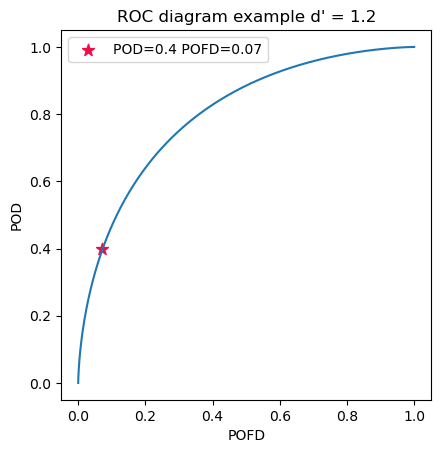

In [5]:
# example ROC diagram

fig,ax = plt.subplots()
dprime1=1.2

pod1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=-0.5*dprime1,scale=1.)
pofd1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=0.5*dprime1,scale=1.)
pod_pt=np.round(pod1[np.argmax(pod1>0.4)],2)
pofd_pt=np.round(pofd1[np.argmax(pod1>0.4)],2)
lab1=f'POD={pod_pt} POFD={pofd_pt}'

ax.scatter(pofd_pt,pod_pt,marker='*',s=80,color='#f10c45',label=lab1)
ax.plot(pofd1,pod1)
ax.set_xlabel('POFD')
ax.set_ylabel('POD')
ax.set_title(f"ROC diagram example d' = {dprime1}")
ax.set_aspect('equal')
ax.legend()

This ROC curve displays the typical connection between $POD$ and $POFD$, for high forecast thresholds $POD$ and $POFD$ (the areas to the right of the threshold) will both be small, indicating a relatively low proportion of "hits" as well as "false alarms". Low forecast thresholds (shift the threshold to the left on the discrimination diagram) will result in relatively high $POD$ and $POFD$, with a large fraction of the observed events resulting in "hits" along with a relatively high fraction of the yes forecasts resulting in false alarms. $POD$ and $POFD$ tend to change "in tandem". The shapes and relative positions of the conditional forecast distributions controls the shape of the $POD$ vs $POFD$ curve, larger separation between these is considered better "discrimination" between observed events and non-events. ($POD=0.4$ and $POFD=0.07$ point is indicated by the red start from the forecast threshold displayed above)

## zero skill reference

It is often helpful to know how the performance of a forecast system compares to a "reference" forecast that we consider having no $skill$ (defined by Murphy 1993 as relative accuracy). Since the ROC diagram provides information regarding the degree of discrimination ability of the forecast, one possible "zero skill" baseline would be a system with no discrimination ability. Such as a system would have no separation between conditional forecast distributions in the discrimination diagram (see example below). Basically, the same forecasts values are provided in anticipation of observed events as they are in anticipation of non-events, which would certaintly not be considered useful or skillful. Since the areas to the right of the threshold for the two conditional distributions would be identical in this situation, the "zero skill" baseline that is often used for ROC diagrams is the $POD=POFD$ line. 

The choice of reference forecast is an important issue in determining a quantitative measure of skill, several studies (e.g., Murphy 1988; Mason 2004; Hamill and Juras 2006) have noted issues with using single-valued reference forecasts to quantify skill, particularly when the verification dataset is aggregated from pooled subsets that have different base rates or forecast variances. Consistent with previous skill score derivations (e.g., Gilbert 1884; Peirce 1884; Doolittle 1885; Heidke 1925; Doswell et al. 1990; Schaefer 1990), we can define the reference forecast as that expected from random chance (intro_2x2_table.ipynb provides additional detail on derivation of the random 2x2 contingency table), obtained from the verification data sample:

$POD_{random} = \frac{a_{random}}{a+c} = \frac{(a+b)(a+c)}{a+c} = a + b = \bar f$

$POFD_{random} = \frac{b_{random}}{b+d} = \frac{(a+b)(b+d)}{b+d} = a + b = \bar f$

$POD_{random}=POFD_{random}$

So, we would expect a random forecast to follow the $POD=POFD$ line on a ROC curve. This line is often provided for visual reference.


Text(0.5, 1.0, "standard normal separated by d'=0.0")

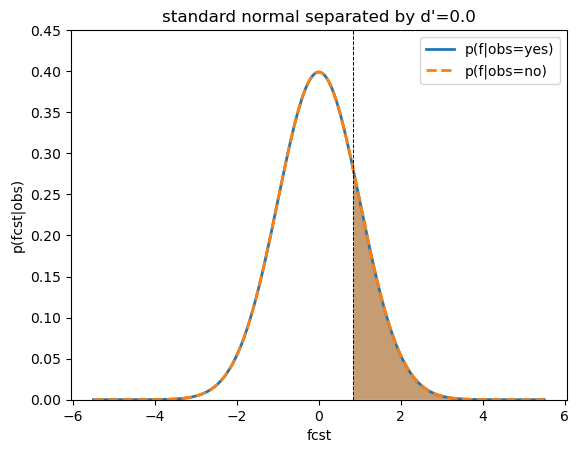

In [6]:
# no discrimination ability: POD=POFD
fig,ax = plt.subplots()
dprime1=0.
x1=np.linspace(-5.5,5.5,1001)
p1=norm.pdf(x1,loc=0.5*dprime1,scale=1.)
p0=norm.pdf(x1,loc=-0.5*dprime1,scale=1.)
ax.plot(x1,p1,label='p(f|obs=yes)',lw=2.)
ax.plot(x1,p0,label='p(f|obs=no)',ls='--',lw=2.)
ax.plot([x1[577],x1[577]],[0,0.45],'k--',lw=0.7)
ax.fill_between(x1[577:],p1[577:],alpha=0.5)
ax.fill_between(x1[577:],p0[577:],alpha=0.5)
ax.legend()
ax.set_xlabel('fcst')
ax.set_ylabel('p(fcst|obs)')
ax.set_ylim(0.,0.45)
ax.set_title(f"standard normal separated by d'={dprime1}")

(0.0, 1.0)

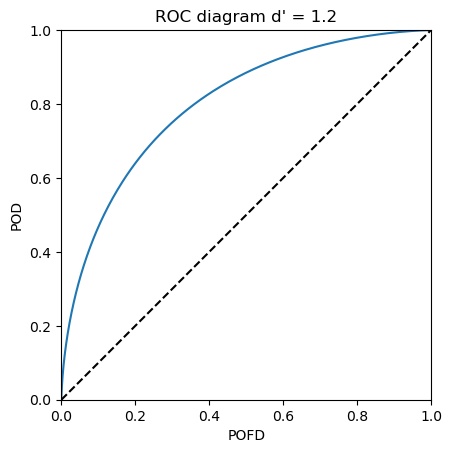

In [7]:
# example ROC diagram including no-skill line

fig,ax = plt.subplots()
dprime1=1.2

pod1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=-0.5*dprime1,scale=1.)
pofd1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=0.5*dprime1,scale=1.)

ax.plot(pofd1,pod1)
ax.plot([0,1],[0,1],'k--')
ax.set_xlabel('POFD')
ax.set_ylabel('POD')
ax.set_title(f"ROC diagram d' = {dprime1}")
ax.set_aspect('equal')
ax.set_ylim(0.,1.)
ax.set_xlim(0.,1.)


## add other scores in the background

In this 2-D $(POD,POFD)$ space, we can define all four elements of the 2x2 contingency table for a specific base rate (see above). This allows us to calculate different scores and plot them in the background of the ROC diagram, similar to how CSI and bias are routinely displayed in the background of performance diagrams. Since many/most scores are functions of the base rate in this 2-D space, it can be informative to see how the behavior of scores change with different base rates. Scores that can be expressed in terms of $POD$ and $POFD$ alone (such as $PSS=POD-POFD$ and $d'$) will be invariant to base rate in this space. Frequency bias will vary significantly with base rate ($bias=POD+\frac{1-\bar x}{\bar x}POFD$) in ROC space. In the example below, $PSS$ is shown in the background as a color fill and $bias$ contours are shown as dashed black lines.

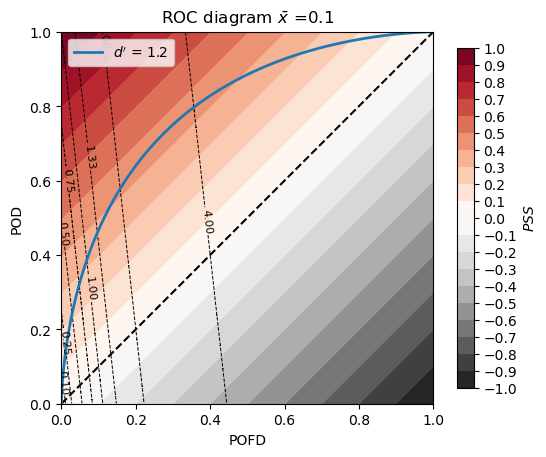

In [8]:
# plot background scores on ROC diagrams

# some functions to assist with score calculation
def pss(a,b,c,d):
    return (a*d-b*c)/(a+c)/(b+d)

def bias(a,b,c,d):
    return (a+b)/(a+c)

xbar=0.1

fig, axs = plt.subplots(figsize=(6,6))

# arrays hold 2d fields of POD, POFD to allow for calculation of scores in background of plots
pod_y=np.arange(0.001,1.0,0.001)
pofd_x=np.arange(0.001,1.0,0.001)
pofd_roc,pod_roc=np.meshgrid(pofd_x,pod_y)

# 2x2 contingency elements in POD,POFD space
aa_roc=xbar*pod_roc
bb_roc=(1-xbar)*pofd_roc
cc_roc=xbar*(1.-pod_roc)
dd_roc=(1-xbar)*(1.-pofd_roc)

# labels and ticks for background score colorbar
label1=r'$PSS$'
extend1='neither'
d_lvls=np.linspace(-1.,1.,21)
d_ticks=np.linspace(-1.,1.,21)

# plot ROC diagram with background score and bias
sc1=axs.contourf(pofd_x,pod_y,pss(aa_roc,bb_roc,cc_roc,dd_roc),levels=d_lvls,cmap='RdGy_r',extend=extend1)
cs0=axs.contour(pofd_x,pod_y,bias(aa_roc,bb_roc,cc_roc,dd_roc),levels=np.array([0.1,0.25,0.5,0.75,1.,1.33,2.,4.,10.]),colors='k',linestyles='dashed',linewidths=0.7)
axs.clabel(cs0, cs0.levels, inline=True, fontsize=8)
plt.colorbar(sc1,orientation='vertical',shrink=0.735,label=label1,ax=axs,ticks=d_ticks)

#zero skill line
axs.plot([0,1],[0,1],'k--')
axs.set_aspect('equal')
axs.set_ylim(0.,1.)
axs.set_xlim(0.,1.)
axs.set_xlabel('POFD')
axs.set_ylabel('POD')
axs.set_title(r'ROC diagram $\bar x$ ='+f'{xbar}')

# plot example ROC curve

dprime1=1.2
pod1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=-0.5*dprime1,scale=1.)
pofd1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=0.5*dprime1,scale=1.)
axs.plot(pofd1,pod1,lw=2,label=r"$d'$ = "+f'{dprime1}')
axs.legend()



## masking out the 'no-skill' region

In this example above, the background scores were displayed in the full 2-D $(POD,POFD)$ space, although the lower right half of the diagram is a region where the forecast would be worse than random (negative skill). It can be helpful to mask out that region in the diagram to clearly indication where the 'no-skill' region is located. In the code example that follows, a matplotlib "patch" is used to plot a hatched pattern in the no-skill region and the 2x2 contingency table elements are set to np.nan to remove that area from any score plotting/calculation. $d'$ is shown in the background of the example below since it is invariant to base rate in $(POD,POFD)$ space and can be helpful in understanding the behavior of forecast systems (e.g., Brooks (2004)).

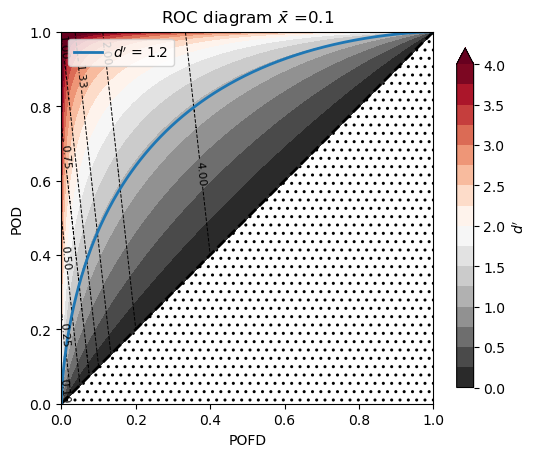

In [9]:
# ROC diagram - mask out "no skill" region

# some functions to assist with score calculation
def dprime(a,b,c,d):
    return norm.ppf(a/(a+c))-norm.ppf(b/(b+d))

def bias(a,b,c,d):
    return (a+b)/(a+c)

# 2x2 contingency elements depend on base rate
xbar=0.1

# nice ROC diagram plot
fig, axs = plt.subplots(figsize=(6,6))

# arrays hold 2d fields of POD, POFD to allow for calculation of scores in background of plots
pod_y=np.arange(0.001,1.0,0.001)
pofd_x=np.arange(0.001,1.0,0.001)
pofd_roc,pod_roc=np.meshgrid(pofd_x,pod_y)

# 2x2 contingency elements in POD,POFD space
aa_roc=xbar*pod_roc
bb_roc=(1-xbar)*pofd_roc
cc_roc=xbar*(1.-pod_roc)
dd_roc=(1-xbar)*(1.-pofd_roc)

# set no skill region to nan
aa_roc[pod_roc<pofd_roc]=np.nan
bb_roc[pod_roc<pofd_roc]=np.nan
cc_roc[pod_roc<pofd_roc]=np.nan
dd_roc[pod_roc<pofd_roc]=np.nan

# labels and ticks for background score colorbar
label1=r"$d'$"
extend1='max'
d_lvls=np.linspace(0.,4.,17)
d_ticks=np.linspace(0.,4.,9)

# plot ROC diagram with background score and bias
sc1=axs.contourf(pofd_x,pod_y,dprime(aa_roc,bb_roc,cc_roc,dd_roc),levels=d_lvls,cmap='RdGy_r',extend=extend1)
plt.colorbar(sc1,orientation='vertical',shrink=0.735,label=label1,ax=axs,ticks=d_ticks)

cs0=axs.contour(pofd_x,pod_y,bias(aa_roc,bb_roc,cc_roc,dd_roc),levels=np.array([0.1,0.25,0.5,0.75,1.,1.33,2.,4.,10.]),colors='k',linestyles='dashed',linewidths=0.7)
axs.clabel(cs0, cs0.levels, inline=True, fontsize=8)

# get data you will need to create a "background patch" to your plot
xmin, xmax = axs.get_xlim()
ymin, ymax = axs.get_ylim()
xy = (xmin+0.001,ymin+0.001)
width = xmax - xmin - 0.002
height = ymax - ymin - 0.002
# create the patch and place it in the back of countourf (zorder!)
p = patches.Rectangle(xy, width, height, hatch='..', linewidth=0,fill=None, zorder=-10)
axs.add_patch(p)

#zero skill line
axs.plot([0,1],[0,1],'k--',lw=2)
axs.set_aspect('equal')
axs.set_ylim(0.,1.)
axs.set_xlim(0.,1.)
axs.set_xlabel('POFD')
axs.set_ylabel('POD')
axs.set_title(r'ROC diagram $\bar x$ ='+f'{xbar}')

# plot ROC curve on diagram

dprime1=1.2
pod1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=-0.5*dprime1,scale=1.)
pofd1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=0.5*dprime1,scale=1.)
axs.plot(pofd1,pod1,lw=2,label=r"$d'$ = "+f'{dprime1}')
axs.legend()


## ROC diagram from arrays of forecasts/observations

The code above plots a "generic" ROC diagram assuming that you already have $POD,POFD$ arrays computed. The code blocks below show how to produce a ROC curve from arrays of forecast and observed values, synthetic data are generated using a beta distribution, following the example in generate_synth_data.ipynb.

In [10]:
# functions to generate synthetic forecasts and observations and compute the 2x2 contingency table

def synth_data(nn,xbar,fbar,sharp,rhoxf):
    # generate synthetic binary obs with base rate = xbar
    # generate synthetic forecasts [continuous beta-distributed probability-like]
    # generate synthetic forecasts [binary with mean forecast = fbar]
    # rhoxf controls the correlation of the bivariate normal that is used to generate obs and fcst-beta
    # sharp controls the normalized sharpness in determining the beta distribution parameters of the fcsts
    cov = np.array([[1.,rhoxf ], [rhoxf,1.]])
    pts = rng.multivariate_normal([0., 0.], cov, size=nn)
    obs_bin=np.zeros_like(pts[:,0])
    xthresh=norm.ppf(1-xbar,0.,1.)
    obs_bin[pts[:,0]>=xthresh]=1.
    sx21=xbar*(1.-xbar)
    sf21=sharp*sx21
    nu1=fbar*(1-fbar)/sf21-1.
    alpha1=fbar*nu1
    beta1=(1.-fbar)*nu1
    fcst_beta=beta.ppf(norm.cdf(pts[:,1],0.,1.), alpha1,beta1)
    fthresh=np.quantile(fcst_beta,1.-fbar)
    fcst_bin=fcst_beta>=fthresh
    return obs_bin,fcst_beta,fcst_bin

def calc_2x2_table(fcst,obs,thresholds):
    # assuming fcst and obs are of the same length, fcst are continuous and obs are binary
    # loop over thresholds and find elements of 2x2 contingency table for each
    # return these in a pandas dataframe
    nthresh=len(thresholds)
    aa=np.full(nthresh,np.nan)
    bb=np.full(nthresh,np.nan)
    cc=np.full(nthresh,np.nan)
    dd=np.full(nthresh,np.nan)
    for j in np.arange(nthresh):
        fthresh=thresholds[j]
        fcst_bin=fcst>=fthresh
        nn=float(len(obs))
        aa[j]=np.sum(obs*fcst_bin)/nn
        bb[j]=np.sum((1.-obs)*fcst_bin)/nn
        cc[j]=np.sum(obs*(1.-fcst_bin))/nn
        dd[j]=np.sum((1.-obs)*(1.-fcst_bin))/nn
    df=pd.DataFrame(data=np.array([thresholds,aa,bb,cc,dd]).T,columns=['thresh','a','b','c','d'])
    return df

def pod(a,b,c,d):
    return a/(a+c)

def pofd(a,b,c,d):
    return b/(b+d)

In [11]:
# these values will generate a large sample of synthetic fcst/obs data with d' approximately 1.2
nn=100000
xbar=0.1
fbar=0.1
rhoxf=0.55
ratio=0.2

obs_pts,fcst_pts,fcst_bin=synth_data(nn,xbar,fbar,ratio,rhoxf)

# set up array of thresholds going from zero to slightly above the max forecast value
# this will produce PODs that vary from 1 to 0, POFDs that vary from 1 to 0
threshs=np.quantile(fcst_pts,np.linspace(0.001,0.999,99))
threshs=np.insert(threshs,0,0.)
threshs=np.append(threshs,np.max(fcst_pts)*1.01)

# generate arrays of 2x2 contingency table elements corresponding with these thresholds
df = calc_2x2_table(fcst_pts,obs_pts,threshs)
df

,thresh,a,b,c,d
0,0.000000e+00,0.10060,0.89940,0.00000,0.00000
1,7.360856e-09,0.10060,0.89840,0.00000,0.00100
2,3.040512e-06,0.10059,0.88822,0.00001,0.01118
3,1.635009e-05,0.10058,0.87805,0.00002,0.02135
4,4.202405e-05,0.10055,0.86789,0.00005,0.03151
...,...,...,...,...,...
96,4.543092e-01,0.01448,0.01708,0.08612,0.88232
97,5.034053e-01,0.01084,0.01053,0.08976,0.88887
98,5.789075e-01,0.00646,0.00473,0.09414,0.89467
99,7.801502e-01,0.00073,0.00027,0.09987,0.89913


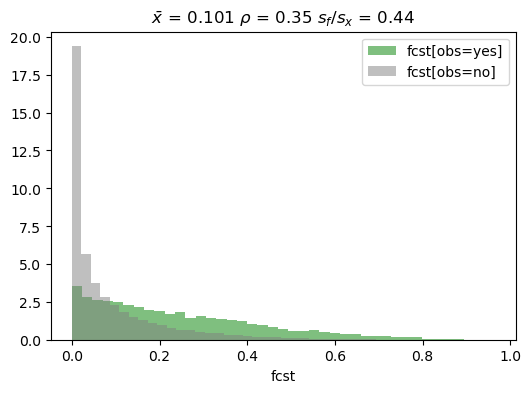

In [12]:
# plot the corresponding discrimination diagram

# calculate some stats
xbar_pts=np.mean(obs_pts)
sx2_pts=np.var(obs_pts,ddof=0)
sf2_pts=np.var(fcst_pts,ddof=0)
rho_pts=np.corrcoef([obs_pts,fcst_pts])[0][1]
sf_sx=np.sqrt(sf2_pts)/np.sqrt(sx2_pts)

# format strings containing these stats in the diagram title
leg1=r' $\rho$' + f' = {np.round(rho_pts,2)}'
sharp=r' $s_f$/$s_x$' + f' = {np.round(sf_sx,2)}'
tit1=r'$\bar x$'+f' = {np.round(xbar_pts,3)}'

fig,axs=plt.subplots(figsize=(6,4))

# obs=yes conditional distribution
axs.hist(fcst_pts[obs_pts>=0.5], bins=41,color='green',density=True,label='fcst[obs=yes]',alpha=.5)
# obs=no conditional distribution
axs.hist(fcst_pts[obs_pts<0.5], bins=41,color='gray',density=True,label='fcst[obs=no]',alpha=.5)
axs.set_title(tit1+leg1+sharp)
axs.set_xlabel('fcst')
axs.legend()

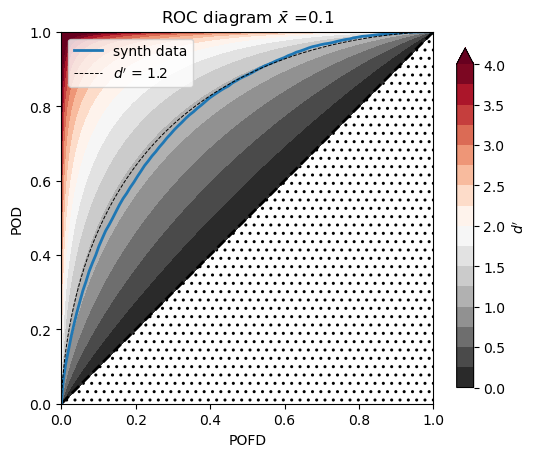

In [13]:
# ROC diagram

# 2x2 contingency elements depend on base rate
xbar=np.mean(obs_pts)

# nice ROC diagram plot
fig, axs = plt.subplots(figsize=(6,6))

# arrays hold 2d fields of POD, POFD to allow for calculation of scores in background of plots
pod_y=np.arange(0.001,1.0,0.001)
pofd_x=np.arange(0.001,1.0,0.001)
pofd_roc,pod_roc=np.meshgrid(pofd_x,pod_y)

# 2x2 contingency elements in POD,POFD space
aa_roc=xbar*pod_roc
bb_roc=(1-xbar)*pofd_roc
cc_roc=xbar*(1.-pod_roc)
dd_roc=(1-xbar)*(1.-pofd_roc)

# set no skill region to nan
aa_roc[pod_roc<pofd_roc]=np.nan
bb_roc[pod_roc<pofd_roc]=np.nan
cc_roc[pod_roc<pofd_roc]=np.nan
dd_roc[pod_roc<pofd_roc]=np.nan

# labels and ticks for background score colorbar
label1=r"$d'$"
extend1='max'
d_lvls=np.linspace(0.,4.,17)
d_ticks=np.linspace(0.,4.,9)

# plot ROC diagram with background score and bias
sc1=axs.contourf(pofd_x,pod_y,dprime(aa_roc,bb_roc,cc_roc,dd_roc),levels=d_lvls,cmap='RdGy_r',extend=extend1)
plt.colorbar(sc1,orientation='vertical',shrink=0.735,label=label1,ax=axs,ticks=d_ticks)

# comment out bias contours in this example
# cs0=axs.contour(pofd_x,pod_y,bias(aa_roc,bb_roc,cc_roc,dd_roc),levels=np.array([0.1,0.25,0.5,0.75,1.,1.33,2.,4.,10.]),colors='k',linestyles='dashed',linewidths=0.7)
# axs.clabel(cs0, cs0.levels, inline=True, fontsize=8)

# get data you will need to create a "background patch" to your plot
xmin, xmax = axs.get_xlim()
ymin, ymax = axs.get_ylim()
xy = (xmin+0.001,ymin+0.001)
width = xmax - xmin - 0.002
height = ymax - ymin - 0.002
# create the patch and place it in the back of countourf (zorder!)
p = patches.Rectangle(xy, width, height, hatch='..', linewidth=0,fill=None, zorder=-10)
axs.add_patch(p)

#zero skill line
axs.plot([0,1],[0,1],'k--',lw=2)
axs.set_aspect('equal')
axs.set_ylim(0.,1.)
axs.set_xlim(0.,1.)
axs.set_xlabel('POFD')
axs.set_ylabel('POD')
axs.set_title(r'ROC diagram $\bar x$ ='+f'{np.round(xbar,2)}')

# plot results - POD vs POFD on ROC
df['POD']=pod(df.a,df.b,df.c,df.d)
df['POFD']=pofd(df.a,df.b,df.c,df.d)
axs.plot(df.POFD,df.POD,lw=2,label='synth data')

# plot standard normal ROC curve d'=1.2 as thin dashed line for comparison to synthetic data
dprime1=1.2
pod1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=-0.5*dprime1,scale=1.)
pofd1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=0.5*dprime1,scale=1.)
axs.plot(pofd1,pod1,'k--',lw=0.7,label=r"$d'$ = "+f'{dprime1}')
axs.legend()

## area under the curve (AUC)

One way to summarize the performance of a forecast system is to calculate the area under the curve ($AUC$) on a ROC diagram. Since a random no-skill forecast ($POD=POFD$) will produce $AUC_{random}=0.5$, a rescaled (skill-score) version can be used that is often called the Gini coefficient (or index) $G_1 = 2 AUC -1$. 

The code below shows how to use the trapezoidal rule (numpy.trapz) to estimate this, along with a function from scikit-learn (sklearn.metrics.roc_auc_score). AUC is closely related to the Mann-Whitney U statistic that is used to test if values from two populations are from the same distribution.


In [14]:
from sklearn import metrics

# AUC from sklearn metrics
print('sklearn AUC = ',np.round(metrics.roc_auc_score(obs_pts,fcst_pts),3))

# AUC from numpy trapz, flipping arrays since pod,pofd go from 1 to 0 in this example
print('trapz AUC = ',np.round(np.trapz(np.flipud(pod(df.a,df.b,df.c,df.d)),np.flipud(pofd(df.a,df.b,df.c,df.d))),3))

sklearn AUC =  0.791
trapz AUC =  0.791


### similarity to standard normal conditional distributions

The synthetic data in the previous example were taken from a beta distribution, and we see in the discrimination diagram that the conditional forecast distributions do not follow a standard normal distribution. However, we find that the corresponding ROC curve roughly follows the constant $d'=1.2$ curve that was produced by standard normal conditional distributions ($AUC$ scores are very similar, see code block below). In real-world forecast situations, we find similar results, ROC curves tend to roughly follow constant $d'$ curves (from standard normal conditional forecast distributions separated by $d'$ standard deviations) even when the underlying distribution of forecasts are non-Gaussian. This is why $d'$ is a useful background score to include on ROC diagram plots.

In [15]:
# AUC from standard normal conditional distributions

dprime1=1.2
pod1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=-0.5*dprime1,scale=1.)
pofd1=norm.cdf(np.linspace(-5.5,5.5,1001),loc=0.5*dprime1,scale=1.)

print(f"d' = {dprime1} AUC = {np.round(np.trapz(pod1,pofd1),3)}")

d' = 1.2 AUC = 0.802


## additional score definitions

Additional score calculations are provided as functions in the code block below. You can swap these in for scores plotted in the background of the ROC diagram and easily visualize how they behave in $(POD,POFD)$ space with different base rates.

In [16]:
# functions for score calculations from 2x2 contingency table

def pod(a,b,c,d):
    return a/(a+c)
    
def sr(a,b,c,d):
    return a/(a+b)    

def pofd(a,b,c,d):
    return b/(b+d)
    
def mr(a,b,c,d):
    return c/(c+d)

def csi(a,b,c,d):
    return a/(a+b+c)

def tversky(a,b,c,d,gamma):
    return a/(a+gamma*b+(1.-gamma)*c)
    
def pss(a,b,c,d):
    return (a*d-b*c)/(a+c)/(b+d)

def css(a,b,c,d):
    return (a*d-b*c)/(a+b)/(c+d)

def qyule(a,b,c,d):
    return (a*d-b*c)/(a*d+b*c)

def mse(a,b,c,d):
    return b+c
    
def srskill(a,b,c,d):
    return (a*d-b*c)/(a+b)/(b+d)
    
def podskill(a,b,c,d):
    return (a*d-b*c)/(a+c)/(c+d)
    
def deelia(a,b,c,d):
    return np.log(b/(a+b))/np.log(a/(a+c))

def edi(a,b,c,d):
    return (np.log(b/(b+d))-np.log(a/(a+c)))/(np.log(b/(b+d))+np.log(a/(a+c)))

def sedi(a,b,c,d):
    return (np.log(b/(b+d))-np.log(a/(a+c))-np.log(d/(b+d))+np.log(c/(a+c)))/(np.log(b/(b+d))+np.log(a/(a+c))+np.log(d/(b+d))+np.log(c/(a+c)))

def hss(a,b,c,d):
    return 2.*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d))

def kappa(a,b,c,d,w):
    return (a*d-b*c)/((1.-w)*(a+c)*(c+d)+w*(a+b)*(b+d))

def dprime(a,b,c,d):
    return norm.ppf(a/(a+c))-norm.ppf(b/(b+d))

def biasodds(a,b,c,d):
    return (a+b)*(b+d)/(a+c)/(c+d)

def oddsr(a,b,c,d):
    return a*d/b/c

def bias(a,b,c,d):
    return (a+b)/(a+c)
    
def phi(a,b,c,d):
    return (a*d-b*c)/np.sqrt((a+c)*(c+d)*(a+b)*(b+d))

def relvalue(a,b,c,d,alpha,xbar):
    if alpha>xbar:
        relval=((1.-alpha)*a-alpha*b)/(1.-alpha)/xbar
    else:
        relval=(alpha*d-(1.-alpha)*c)/alpha/(1.-xbar)
    return relval

def betafa(a,b,c,d):
    return (a/(a+c))/(b/(b+d))
    
def betame(a,b,c,d):
    return (d/(b+d))/(c/(a+c))

def alphafa(a,b,c,d):
    return (a/(a+c))/(a/(a+c)+b/(b+d))
    
def alphame(a,b,c,d):
    return (c/(a+c))/(d/(b+d)+c/(a+c))
